In [23]:
# To have each Python cell auto-formatted
# See: https://black.readthedocs.io
%load_ext lab_black

INFO:blib2to3.pgen2.driver:Generating grammar tables from /home/jovyan/.local/lib/python3.6/site-packages/blib2to3/Grammar.txt
INFO:blib2to3.pgen2.driver:Writing grammar tables to /home/jovyan/.cache/black/20.8b1/Grammar3.6.9.final.0.pickle
INFO:blib2to3.pgen2.driver:Writing failed: [Errno 2] No such file or directory: '/home/jovyan/.cache/black/20.8b1/tmpo8m0ns97'
INFO:blib2to3.pgen2.driver:Generating grammar tables from /home/jovyan/.local/lib/python3.6/site-packages/blib2to3/PatternGrammar.txt
INFO:blib2to3.pgen2.driver:Writing grammar tables to /home/jovyan/.cache/black/20.8b1/PatternGrammar3.6.9.final.0.pickle
INFO:blib2to3.pgen2.driver:Writing failed: [Errno 2] No such file or directory: '/home/jovyan/.cache/black/20.8b1/tmp30d950_f'


<div class="alert alert-block alert-danger">
    This notebook is for TensorFlow 2 only.
    TensorFlow 1 does not support data auto-sharding.
</div>

# Training MNIST with TensorFlow

## Introduction
Recognizing handwritten digits based on the [MNIST (Modified National Institute of Standards and Technology) data set](http://yann.lecun.com/exdb/mnist/) is the "Hello, World" example of machine learning.
Each (anti-aliased) black-and-white image represents a digit from 0 to 9 and has been fit into a 28x28 pixel bounding box.
The problem of recognizing digits from handwriting is, for instance, important to the postal service when automatically reading zip codes from envelopes.

### What You'll Learn
We'll show you how to use TensorFlow to build a model with a convolutional layer and a fully connected layer to perform the multi-class classification of images provided.

The example in the notebook includes both training a model in the notebook and running a [distributed](https://www.tensorflow.org/guide/distributed_training) `TFJob` on the cluster, so you can easily scale up your own models.
For the distributed training job you'll need to package the complete trainer code in a Docker image.
We'll show you how to do that with Kubeflow Fairing, so that you do not have to leave your favourite notebook environment at all!
We'll also include instructions for local development, in case you prefer that.

<div class="alert alert-block alert-info">
<b>Kubernetes Nomenclature</b><br>
    <code>TFJob</code> is a <a href="https://kubernetes.io/docs/concepts/extend-kubernetes/api-extension/custom-resources/">custom resource (definition) (CRD)</a> provided by the <a href="https://www.kubeflow.org/docs/reference/tfjob/v1/tensorflow/">TensorFlow operator</a>.
    <a href="https://kubernetes.io/docs/concepts/extend-kubernetes/operator/">Operators</a> extend Kubernetes by capturing domain-specific knowledge on how to deploy and run an application or service, how to deal with failures, and so on.
    The lifecycle of a <code>TFJob</code> is managed by the TensorFlow operator controller.
    A distributed TensorFlow job typically consists of the following processes:
    <ul>
        <li>The <b>chief</b> ('master') is responsible for orchestrating the training and performing supplementary tasks, such as initializing the graph, checkpointing, and, saving logs for TensorBoard, and saving the model. It also manages failures and restarts. If the chief itself fails, the training is restarted from the last available checkpoint.</li>
        <li>The <b>workers</b>, as you might expect, do the actual work of training the model. In certain configurations, worker 0 may also act as the chief.</li>
        <li><b>Parameter servers</b> (ps) provide a distributed data store for the model parameters.</li>
        <li>An <b>Evaluator</b> is used to compute evaluation metrics.</li>
    </ul>
    The TensorFlow operator <a href="https://github.com/kubeflow/tf-operator/blob/master/tf_job_design_doc.md#controller">controller</a> takes care of the <a href="https://www.tensorflow.org/guide/distributed_training#TF_CONFIG"><code>TF_CONFIG</code></a> environment variable, which is required for distributed training.
</div>

### What You'll Need
All you need is this notebook.
If you prefer to create your Docker image locally (i.e. outside of the Kubernetes cluster), you must have a [Docker](https://www.docker.com/products/container-runtime) client on your machine and configured to work with your own container registry.
For Kubernetes commands to be run outside of the cluster, [`kubectl`](https://kubernetes.io/docs/reference/kubectl/kubectl/) is required.

## Prerequisites
Before we proceed, let's check that we're using the right image, that is, [TensorFlow](https://www.tensorflow.org/api_docs/) is available:

In [24]:
! pip list | grep tensorflow
! pip install tensorflow_datasets

tensorflow               2.2.0
tensorflow-datasets      4.2.0
tensorflow-estimator     2.2.0
tensorflow-metadata      0.28.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


To package the trainer in a container image, we shall need a file (on our cluster) that contains the code as well as a file with the resource definitition of the job for the Kubernetes cluster:

In [25]:
TRAINER_FILE = "mnist.py"
KUBERNETES_FILE = "tfjob-mnist.yaml"

We also want to capture output from a cell with [`%%capture`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture) that usually looks like `some-resource created`.
To that end, let's define a helper function:

In [26]:
import re

from IPython.utils.capture import CapturedIO


def get_resource(captured_io: CapturedIO) -> str:
    """
    Gets a resource name from `kubectl apply -f <configuration.yaml>`.

    :param str captured_io: Output captured by using `%%capture` cell magic
    :return: Name of the Kubernetes resource
    :rtype: str
    :raises Exception: if the resource could not be created
    """
    out = captured_io.stdout
    matches = re.search(r"^(.+)\s+created", out)
    if matches is not None:
        return matches.group(1)
    else:
        raise Exception(
            f"Cannot get resource as its creation failed: {out}. It may already exist."
        )

## How to Load and Inspect the Data
We grab the MNIST data set with the aid of `tensorflow_datasets`.

INFO:absl:Load dataset info from datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset for split train, from datasets/mnist/3.0.1


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


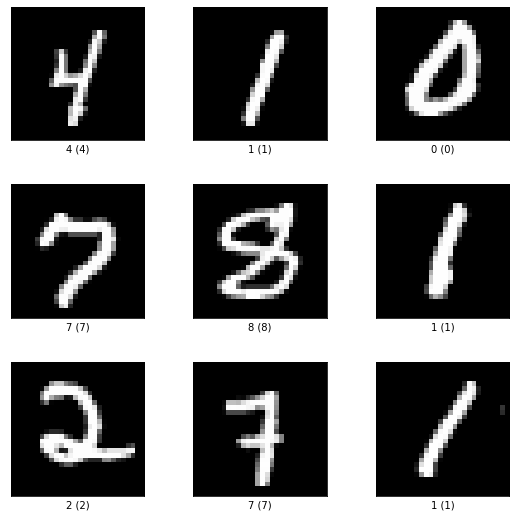

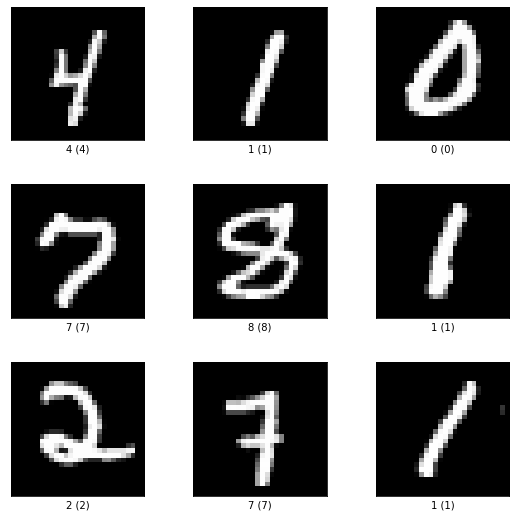

In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt

mnist, info = tfds.load(
    name="mnist", split="train", data_dir="datasets", download=False, with_info=True
)
tfds.show_examples(info, mnist)

We can easily read off the shape of the input tensors that shows the images are all 28x28 pixels, but we do not yet know whether their greyscale values have been scaled to the [0, 1] range or not:

In [28]:
for example in mnist.take(1):
    squeezed = tf.squeeze(example["image"])
    print(tf.math.reduce_min(squeezed), tf.math.reduce_max(squeezed))

tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)


No, they have not.
This means we have to do this in the training and before serving!

In [29]:
# Clear variables as we have no need for these any longer
del mnist, squeezed

<div class="alert alert-block alert-info">
    Before we proceed, we separate the <code>epoch</code> hyperparameter from the main code.
    The reason we do that is to ensure we can run the notebook in so-called headless mode with <a href="https://papermill.readthedocs.io/en/latest/">Papermill</a> for custom parameters.
    This allows us to test the notebooks end-to-end, automatically.
    If you check the <a href="https://jupyterlab.readthedocs.io/en/stable/user/notebook.html#notebook">cell tag</a> of the next cell, you can see it is tagged as <code>parameters</code>.
    Feel free to ignore it!
</div>

In [30]:
epochs = 10

## How to Train the Model in the Notebook
Since we ultimately want to train the model in a distributed fashion (potentially on GPUs), we put all the code in a single cell.
That way we can save the file and include it in a container image:

In [31]:
%%writefile $TRAINER_FILE
import argparse
import logging

import tensorflow as tf
import tensorflow_datasets as tfds

logging.getLogger().setLevel(logging.INFO)


def get_datasets(buffer_size):
    datasets, ds_info = tfds.load(name="mnist", data_dir="datasets", download=False, with_info=True, as_supervised=True)
    mnist_train, mnist_test = datasets["train"], datasets["test"]

    def scale(image, label):
        image = tf.cast(image, tf.float32) / 255
        return image, label

    train_dataset = mnist_train.map(scale).cache().shuffle(buffer_size).repeat()
    test_dataset = mnist_test.map(scale)

    return train_dataset, test_dataset


def compile_model(args):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=args.learning_rate, momentum=args.momentum
        ),
        metrics=["accuracy"],
    )
    return model


def main():
    parser = argparse.ArgumentParser(description="TensorFlow MNIST Training Job")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="Batch size for training (default: 64)",
    )
    parser.add_argument(
        "--buffer-size",
        type=int,
        default=10000,
        metavar="N",
        help="Number of training examples to buffer before shuffling" "default: 10000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=5,
        metavar="N",
        help="Number of epochs to train (default: 5)",
    )
    parser.add_argument(
        "--steps",
        type=int,
        default=10,
        metavar="N",
        help="Number of batches to train the model on in each epoch (default: 10)",
    )
    parser.add_argument(
        "--learning-rate",
        type=float,
        default=0.5,
        metavar="N",
        help="Learning rate (default: 0.5)",
    )
    parser.add_argument(
        "--momentum",
        type=float,
        default=0.1,
        metavar="N",
        help="Accelerates SGD in the relevant direction and dampens oscillations (default: 0.1)",
    )

    args, _ = parser.parse_known_args()

    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    logging.debug(f"num_replicas_in_sync: {strategy.num_replicas_in_sync}")
    global_batch_size = args.batch_size * strategy.num_replicas_in_sync

    # Datasets need to be created after instantiation of `MultiWorkerMirroredStrategy`
    train_dataset, test_dataset = get_datasets(buffer_size=args.buffer_size)
    train_dataset = train_dataset.batch(batch_size=global_batch_size)
    test_dataset = test_dataset.batch(batch_size=global_batch_size)

    # See: https://www.tensorflow.org/api_docs/python/tf/data/experimental/DistributeOptions
    dataset_options = tf.data.Options()
    dataset_options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.DATA
    )
    train_datasets_sharded = train_dataset.with_options(dataset_options)
    test_dataset_sharded = test_dataset.with_options(dataset_options)

    # Model compilation must be within `strategy.scope()`
    # See: https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
    with strategy.scope():
        model = compile_model(args=args)

    # We cannot set `steps_per_epoch = None` with MirroredStrategy
    # See: https://github.com/tensorflow/tensorflow/issues/25254
    model.fit(train_datasets_sharded, epochs=args.epochs, steps_per_epoch=args.steps)
    eval_loss, eval_acc = model.evaluate(test_dataset_sharded, verbose=0, steps=args.steps)

    # Log metrics for Katib
    logging.info("loss={:.4f}".format(eval_loss))
    logging.info("accuracy={:.4f}".format(eval_acc))


if __name__ == "__main__":
    main()

Overwriting mnist.py


That saves the file as defined by `TRAINER_FILE` but it does not run it.

The log entries for 'Katib' are to re-use the same file for [hyperparameter tuning](../../katib/Hyperparameter%20Tuning.ipynb), which is done in a separate notebook.
All you need to know for that is that Katib looks for `key=value` entries in the logs.

<div class="alert alert-block alert-info">
<b>A Note on Activation Functions</b><br>
    A common choice for <a href="https://arxiv.org/abs/1606.02228">activation functions</a> is a ReLU (Rectified Linear Unit).
    It is linear for non-negative values and zero for negative ones.
    The <a href="https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/">main benefits of ReLU</a> as opposed to sigmoidal functions (e.g. logistic or `tanh`) are:
    <ul>
        <li>ReLU and its gradient are very cheap to compute;</li>
        <li>Gradients are less likely to vanish, because for (non-)negative values its gradient is constant and therefore does not saturate, which for deep neural networks can <a href="https://dl.acm.org/doi/10.1145/3065386">accelerate convergence;</a></li>
        <li>ReLU has a regularizing effect, because it promotes <a href="https://www.researchgate.net/publication/215616967_Deep_Sparse_Rectifier_Neural_Networks">sparse representations</a> (i.e. some nodes' weights are zero);</li> 
        <li>Empirically it has been found to work well.</li>
    </ul>
    ReLU activation functions can cause neurons to 'die' because a large, negative (learned) bias value causes all inputs to be negative, which in turn leads to a zero output.
    The neuron has thus become incapable of discriminating different input values.
    So-called leaky ReLU activations functions address that issue; these functions are linear but non-zero for negative values, so that their gradients are small but non-zero.
    <a href="https://arxiv.org/abs/1511.07289">ELUs</a>, or exponential linear units, are another solution to the problem of dying neurons.
</div>

<div class="alert alert-block alert-info">
    <b>A Note on CNNs</b><br>
    While it is not our intention to cover the basics of <a href="https://www.deeplearningbook.org/contents/convnets.html">convolutional neural networks</a> (CNNs), there are a few matters worth mentioning.
    Convolutional layers are spatial feature extractors for images.
    A series of convolutional kernels (of the same dimensions) is applied to the image to obtain different versions of the same base image (i.e. filters).
    These filters extract patterns hierarchically.
    In the first layer, filters typically capture dots, edges, corners, and so on.
    With each additional layer, these patterns become more complex and turn from basic geometric shapes into constituents of objects and entire objects.
    That is why often the number of filters increases with each additional convolutional layer: to extract more complex patterns.<br><br>
    Convolutional layers are often followed by a pooling layer to down-sample the input.
    This aids in lowering the computational burden as we increase the number of filters.
    A max pooling layer simply picks the largest value of pixels in a small (rectangular) neighbourhood of a single channel (e.g. RGB). 
    This has the effect of making features <em>locally</em> translation-invariant, which is often desired: whether a feature of interest is on the left or right edge of a pooling window, which is also referred to as a kernel, is largely irrelevant to the problem of image classification.
    Note that this may not always be a desired characteristic and depends on the size of the pooling kernel.
    For instance, the precice location of tissue damage in living organisms or defects on manufactured products may be very significant indeed.
    Pooling kernels are generally chosen to be relatively small compared to the dimensions of the input, which means that local translation invariance is often desired. <br><br>
    Another common component of CNNs is a dropout layer.
    <a href="http://jmlr.org/papers/v15/srivastava14a.html">Dropout</a> provides a mechanism for regularization that has proven successful in many applications.
    It is suprisingly simple: some nodes' weights (and biases) in a specific layer are set to zero <em>at random</em>, that is, arbitrary nodes are removed from the network during the training step.
    This causes the network to not rely on any single node (a.k.a. neuron) for a feature, as each node can be dropped at random.
    The network therefore has to learn redundant representations of features.
    This is important because of what is referred to as <em>internal covariate shift</em> (often mentioned in connection with <a href="http://proceedings.mlr.press/v37/ioffe15.html">batch normalization</a>): the change of distributions of internal nodes' weights due to all other layers, which can cause nodes to stop learning (i.e. updating their weights).
    Thanks to dropout, layers become more robust to changes, although it also means it limits what can be learnt (as always with regularization).
    Still, dropout is the neural network's equivalent of the saying you should never put all your eggs in one basket.
    Layers with a high risk of overfitting (e.g. layers with many units and lots of inputs) typically have a higher dropout rate.
    <br><br>
    A nice visual explanation of convolutional layers is available <a href="https://cezannec.github.io/Convolutional_Neural_Networks/">here</a>.
    If you're curious what a CNN "sees" while training, you can have a look <a href="https://poloclub.github.io/cnn-explainer/">here</a>.
</div>

Let's see if our code is correct by running it from within our notebook:

In [32]:
%run $TRAINER_FILE --epochs $epochs

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO
INFO:absl:Load dataset info from datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset for split None, from datasets/mnist/3.0.1


Epoch 1/10
10/10 [==============================] - 0s 11ms/step - accuracy: 0.2781 - loss: 2.1370
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - accuracy: 0.3484 - loss: 2.0222
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - accuracy: 0.5500 - loss: 1.4497
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - accuracy: 0.6484 - loss: 1.1029
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - accuracy: 0.7250 - loss: 0.8732
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - accuracy: 0.8453 - loss: 0.4687
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - accuracy: 0.8813 - loss: 0.4247
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - accuracy: 0.8750 - loss: 0.3636
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - accuracy: 0.9094 - loss: 0.3014
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - accuracy: 0.8891 - loss: 0.3750


INFO:root:loss=0.2435
INFO:root:accuracy=0.9312


This trains the model in the notebook, but does not distribute it across nodes (a.k.a. pods) in our cluster.
To that end, we have to first create a Docker image with the code, push it to a registry (e.g. [Docker Hub](https://hub.docker.com/), [Azure Container Registry](https://azure.microsoft.com/en-us/services/container-registry/), [ECR](https://aws.amazon.com/ecr/), [GCR](https://cloud.google.com/container-registry/), or similar), and then define the Kubernetes resource that uses the image.

## How to Create a Docker Image with Kubeflow Fairing
Kubeflow Fairing is a Python SDK that allows you to build, push, and optionally run containerized ML models without leaving Jupyter!
To build and push Docker images from within a notebook, please check out the [Kubeflow Fairing notebook](../../fairing/Kubeflow%20Fairing.ipynb).
All you need is the `TRAINER_FILE` and access to a container registry.

## How to Create a Docker Image Manually
If you are comfortable with Docker (or prefer to use it as a part of your CI/CD setup), you can create a Dockerfile as follows.
You do have to download the `TRAINER_FILE` contents to your local machine.
The Kubernetes cluster does not have a Docker daemon available to build your image, so you must do it locally.
It uses [containerd](https://containerd.io/) to run workloads (only) instead.

The Dockerfile looks as follows:

```
FROM mesosphere/kubeflow:1.0.1-0.5.0-tensorflow-2.2.0-gpu
ADD mnist.py /
ADD datasets /datasets

ENTRYPOINT ["python", "-u", "/mnist.py"]
```

If GPU support is not needed, you can leave off the `-gpu` suffix from the image.
`mnist.py` is the trainer code you have to download to your local machine.

Then it's easy to push images to your container registry:

```bash
docker build -t <docker_image_name_with_tag> .
docker push <docker_image_name_with_tag>
```

The image is available as `mesosphere/kubeflow:mnist-tensorflow-2.2-1.0.1-0.5.0` in case you want to skip it for now.

## How to Create a Distributed `TFJob`
For large training jobs, we wish to run our trainer in a distributed mode.
Once the notebook server cluster can access the Docker image from the registry, we can launch a distributed PyTorch job.

The specification for a distributed `TFJob` is defined using YAML:

In [33]:
%%writefile $KUBERNETES_FILE
apiVersion: "kubeflow.org/v1"
kind: "TFJob"
metadata:
  name: "tfjob-mnist"
spec:
  tfReplicaSpecs:
    Worker:
      replicas: 2
      restartPolicy: Never
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: tensorflow
              # modify this property if you would like to use a custom image
              image: mesosphere/kubeflow:mnist-tensorflow-2.2-1.0.1-0.5.0
              args:
                - --epochs
                - "15"
                - --steps
                - "250"
              # Comment out these resources when using only CPUs
              resources:
                limits:
                  nvidia.com/gpu: 1

Overwriting tfjob-mnist.yaml


This `spec.tfReplicaSpecs.Worker.replicas` configuration defines two worker pods (`tfjob-mnist-worker-0` and `tfjob-mnist-worker-1`).

Custom training arguments can be passed to the container by means of the `spec.containers.args`.
What is supported is visible in `main()` of `mnist.py`.

The job can run in parallel on CPUs or GPUs, provided these are available in your cluster.
To switch to CPUs or define resource limites, please adjust `spec.containers.resources` as required.    
It is best to change the image name listed under the comment of the specification to use an equivalent image in your own container registry, to ensure everythng works as expected.

You can either execute the following commands on your local machine with `kubectl` or directly from the notebook.
If you do run these locally, you cannot rely on cell magic, so you have to manually copy-paste the variables' values wherever you see `$SOME_VARIABLE`.
If you execute the following commands on your own machine (and not inside the notebook), you obviously do not need the bang `!` either.
In that case, you have to set the user namespace for all subsequent commands:

```
kubectl config set-context --current --namespace=<insert-namespace>
```

Please change the namespace to whatever has been set up by your administrator.

Let's deploy the distributed training job:

In [34]:
%%capture tf_output --no-stderr
! kubectl create -f $KUBERNETES_FILE

In [35]:
TF_JOB = get_resource(tf_output)

To see the job status, use the following command:

In [36]:
! kubectl describe $TF_JOB

Name:         tfjob-mnist
Namespace:    mlops
Labels:       <none>
Annotations:  <none>
API Version:  kubeflow.org/v1
Kind:         TFJob
Metadata:
  Creation Timestamp:  2021-03-17T07:28:56Z
  Generation:          1
  Managed Fields:
    API Version:  kubeflow.org/v1
    Fields Type:  FieldsV1
    fieldsV1:
      f:spec:
        .:
        f:tfReplicaSpecs:
          .:
          f:Worker:
            .:
            f:replicas:
            f:restartPolicy:
            f:template:
              .:
              f:metadata:
                .:
                f:annotations:
                  .:
                  f:sidecar.istio.io/inject:
              f:spec:
    Manager:      kubectl
    Operation:    Update
    Time:         2021-03-17T07:28:56Z
    API Version:  kubeflow.org/v1
    Fields Type:  FieldsV1
    fieldsV1:
      f:spec:
        f:cleanPodPolicy:
        f:tfReplicaSpecs:
          f:Worker:
            f:template:
              f:metadata:
                f:creationTimest

You should now be able to see the created pods matching the specified number of workers.

In [37]:
! kubectl get pods -l job-name=tfjob-mnist

NAME                   READY   STATUS    RESTARTS   AGE
tfjob-mnist-worker-0   0/1     Pending   0          2s
tfjob-mnist-worker-1   0/1     Pending   0          2s


In case of issues, it may be helpful to see the last ten events within the cluster:

```bash
! kubectl get events --sort-by='.lastTimestamp' | tail
```

To stream logs from the worker-0 pod to check the training progress, run the following command:

In [38]:
! kubectl logs -f tfjob-mnist-worker-0

To delete the job, run the following command:

In [39]:
! sdfkubectl delete $TF_JOB

/bin/bash: sdfkubectl: command not found
